In [1]:
import xarray as xr
import pickle
import cmocean as cm
import matplotlib.pyplot as plt
import pickle
import netCDF4 as nc
import numpy as np
plt.style.use('seaborn-whitegrid')
import warnings
warnings.filterwarnings('ignore')
import cmocean as cm
import glob
from salishsea_tools import viz_tools
import arrow

%matplotlib inline

In [2]:
import time

## goal: contemporary climatology of air-sea CO2 fluxes for patrick duke collaboration



## technical notes from SEA:

- using model version 201905, from here:

`/results2/SalishSea/nowcast-green.201905/ddmmmyy/SalishSea_1d_YYYYMMDD_YYYYMMDD_prod_T.nc`

- for 2013-2017 use wrap version, should be better (SEA)

`/results2/SalishSea/nowcast-green.201905_wrap/ddmmmyy/SalishSea_1d_YYYYMMDD_YYYYMMDD_prod_T.nc`

processing notes - for this analysis we need xarray > 0.15, 
I use a special python environment that I built  `conda activate py37` to get the xarray I need.

I believe we may not have prod_T on salish for nowcast-green.201905, corresp. with SEA: is on nearline if we need it. 

### workhorse fxns

In [3]:

def get_arrow_array(start,end):
    start_run = arrow.get(start)
    end_run = arrow.get(end)
    arrow_array = []
    for r in arrow.Arrow.span_range('day', start_run, end_run):
        arrow_array.append(r)
    return arrow_array

def get_filear(arrow_array):
    dayslen = len(arrow_array)
    filear = []
    for i in range(0,dayslen):
        tdate = arrow_array[i][0]
        ddmmmyy = tdate.format('DDMMMYY').lower()
        ymd = tdate.format('YYYYMMDD')
        nc_sens = f'/results2/SalishSea/nowcast-green.201905/*/SalishSea*{ymd}*prod_T.nc'
        w = glob.glob(nc_sens)
        filear.append(w)
    return filear

def get_filear_wrap(arrow_array):
    dayslen = len(arrow_array)
    filear = []
    for i in range(0,dayslen):
        tdate = arrow_array[i][0]
        ddmmmyy = tdate.format('DDMMMYY').lower()
        ymd = tdate.format('YYYYMMDD')
        nc_sens = f'/results2/SalishSea/nowcast-green.201905_wrap/*/SalishSea*{ymd}*prod_T.nc'
        w = glob.glob(nc_sens)
        filear.append(w)
    return filear



def get_areaweighted_nc(yr, wrap = False ):
    ncnam = f'SalishSeaCast201905_co2flux_mmol_m2_day_yr{yr}.nc'
    print(ncnam)
    start = f'{yr}-01-01'
    end = f'{yr}-12-31'

    w = time.time()
    arrow_array = get_arrow_array(start,end)
    if wrap:
        filear = get_filear_wrap(arrow_array)
    else:
        filear = get_filear(arrow_array)

    tdat = xr.open_mfdataset(filear)
    w3 = time.time()
    print('opened')
    print(w3-w)

    sec_day = 60*60*24 #CONVERT FROM MMOL/M2/SEC TO MMOL/M2/DAY
    #factor of 1.11 is asselin filter factor correction

    co2 = tdat.co2_flux_mmol_m2_s.weighted(tmesh.area).mean(dim=["y", "x"]) * 1.11 * sec_day 
    co2.name = 'co2flux'
    co2.attrs=dict(
            description="201905 area-weighted co2 flux, asselin correction applied (1.11)",
            units="mmol/m2/day",
        )
    co2.to_netcdf(ncnam)

In [4]:
## open mesh mask 

tmesh = xr.open_dataset('/data/tjarniko/MEOPAR/grid/mesh_mask201702.nc')
tmesh['area'] = tmesh['e1t'][0,:,:] * tmesh['e2t'][0,:,:] * tmesh['tmaskutil'][0,:,:] 


In [5]:
extract = True
# if extract:
#     get_areaweighted_nc(2013, wrap = False )
#     get_areaweighted_nc(2014, wrap = False )
#     get_areaweighted_nc(2015, wrap = False )
#     get_areaweighted_nc(2016, wrap = False )
#     get_areaweighted_nc(2017, wrap = False )

    # get_areaweighted_nc(2018, wrap = False )
    # get_areaweighted_nc(2019, wrap = False )
    # get_areaweighted_nc(2020, wrap = False )
    # get_areaweighted_nc(2021, wrap = False )
    # get_areaweighted_nc(2022, wrap = False )

## open and plot 5 years of data

In [6]:
y2013 = xr.open_dataset('old/SalishSeaCast201905_co2flux_mmol_m2_day_yr2013.nc')
y2014 = xr.open_dataset('old/SalishSeaCast201905_co2flux_mmol_m2_day_yr2014.nc')
y2015 = xr.open_dataset('old/SalishSeaCast201905_co2flux_mmol_m2_day_yr2015.nc')
y2016 = xr.open_dataset('old/SalishSeaCast201905_co2flux_mmol_m2_day_yr2016.nc')
y2017 = xr.open_dataset('old/SalishSeaCast201905_co2flux_mmol_m2_day_yr2017.nc')


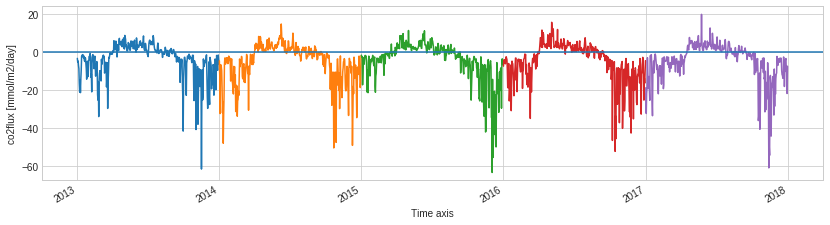

In [7]:
fact = 0.4
fig, axs = plt.subplots(1,1, figsize=(35*fact, 8*fact), facecolor='w', edgecolor='k')


y2013.co2flux.plot(ax = axs)
y2014.co2flux.plot(ax = axs)
y2015.co2flux.plot(ax = axs)
y2016.co2flux.plot(ax = axs)
y2017.co2flux.plot(ax = axs)

axs.axhline(y=0)

In [8]:

c2013 = y2013.co2flux.values
c2014 = y2014.co2flux.values
c2015 = y2015.co2flux.values
c2016 = y2016.co2flux.values
c2017 = y2017.co2flux.values

c2016_nl = np.delete(c2016, 59) #remove leap day

# put 5 available years, 
climat = np.zeros([5,365])
climat[0,:] = c2013
climat[1,:] = c2014
climat[2,:] = c2015
climat[3,:] = c2016_nl
climat[4,:] = c2017

climatology_2013_2017 = np.nanmean(climat, axis = 0)

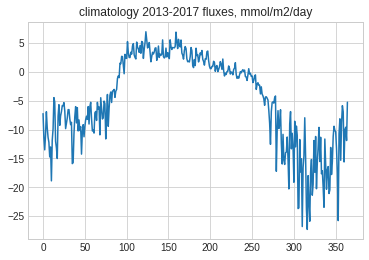

In [9]:
import pandas as pd

plt.plot(climatology_2013_2017)
plt.title('climatology 2013-2017 fluxes, mmol/m2/day')
#np.nanmean(climatology_2013_2017)

yr = 2015
times = pd.date_range(f"{yr}/01/01",f"{yr+1}/01/01",freq='D',closed='left')
savenam = 'SSC201905.wrap-climatology_2013-2017.nc'
data_vars = {'co2flux':(['time_counter'], climatology_2013_2017,
{'units': 'mmol/m2/day',
'long_name':'co2flux'}),
}
# define coordinates
coords = {'time_counter': (['time_counter'], times),
        }
# define global attributes
attrs = {'made in':'analysis_tereza/notebooks/carbon_dev/For_PD/co2fluxSummary2013-2022',
'desc': '5 year averaged climatology, area-weighted, 2013-2017, asselin filt applied'
}
ds = xr.Dataset(data_vars=data_vars,
coords=coords,
attrs=attrs)
ds.to_netcdf(savenam)

### monthly gridded product and climatology. 

In [10]:
yr = 2013; wrap = False
ncnam = f'SalishSeaCast201905_co2flux_mmol_m2_day_yr{yr}.nc'
print(ncnam)
start = f'{yr}-01-01'
end = f'{yr}-12-31'

w = time.time()
arrow_array = get_arrow_array(start,end)
if wrap:
    filear = get_filear_wrap(arrow_array)
else:
    filear = get_filear(arrow_array)

tdat = xr.open_mfdataset(filear)
w3 = time.time()
print('opened')
print(w3-w)

sec_day = 60*60*24 #CONVERT FROM MMOL/M2/SEC TO MMOL/M2/DAY
#factor of 1.11 is asselin filter factor correction

#     co2 = tdat.co2_flux_mmol_m2_s.weighted(tmesh.area).mean(dim=["y", "x"]) * 1.11 * sec_day 
#     co2.name = 'co2flux'
#     co2.attrs=dict(
#             description="201905 area-weighted co2 flux, asselin correction applied (1.11)",
#             units="mmol/m2/day",
#         )
#     co2.to_netcdf(ncnam)

SalishSeaCast201905_co2flux_mmol_m2_day_yr2013.nc
opened
132.13596987724304


In [18]:
yr = 2013; wrap = False

def get_monthly_data_gridded(yr, wrap = False):
    ncnam = f'SalishSeaCast201905_co2flux_monthly_yr{yr}.nc'
    print(ncnam)
    start = f'{yr}-01-01'
    end = f'{yr}-12-31'

    w = time.time()
    arrow_array = get_arrow_array(start,end)
    if wrap:
        filear = get_filear_wrap(arrow_array)
    else:
        filear = get_filear(arrow_array)

    tdat2 = xr.open_mfdataset(filear)
    w3 = time.time()
    print('opened')
    print(w3-w)

    sec_day = 60*60*24 #CONVERT FROM MMOL/M2/SEC TO MMOL/M2/DAY
    #factor of 1.11 is asselin filter factor correction

    co2 = tdat.co2_flux_mmol_m2_s.groupby('time_counter.month').mean()  * 1.11 * sec_day 
    co2.name = 'co2flux'
    co2.attrs=dict(
            description="201905 monthly co2 flux, asselin correction applied (1.11)",
            units="mmol/m2/day",
        )
    co2.to_netcdf(ncnam)
        


In [19]:
if extract:
    get_monthly_data_gridded(2013)
    get_monthly_data_gridded(2014) 
    get_monthly_data_gridded(2015)
    get_monthly_data_gridded(2016)
#     get_monthly_data_gridded(2017)

SalishSeaCast201905_co2flux_monthly_yr2013.nc
opened
131.26869893074036
SalishSeaCast201905_co2flux_monthly_yr2014.nc
opened
188.2368667125702
SalishSeaCast201905_co2flux_monthly_yr2015.nc
opened
189.8788447380066
SalishSeaCast201905_co2flux_monthly_yr2016.nc
opened
203.59533262252808
SalishSeaCast201905_co2flux_monthly_yr2017.nc


IndexError: list index out of range

# 12 x 4 full dataset, gridded

In [20]:
yr = 2017
start = f'{yr}-01-01'
end = f'{yr}-12-31'

w = time.time()
arrow_array = get_arrow_array(start,end)
filear = get_filear(arrow_array)